In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np

## 1. & 2. Load Dataset and Data Preprocessing

In [ ]:
# Define transformations
# ToTensor() converts images to tensors
# Normalize() shifts pixel values from [0, 1] to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Load the full training dataset

In [ ]:
full_train_dataset = datasets.FashionMNIST(
    root='.',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]


## Load the test dataset

In [ ]:
test_dataset = datasets.FashionMNIST(
    root='.',
    train=False,
    download=True,
    transform=transform
)

## Split training data into training and validation sets (50k train, 10k val)

In [ ]:
train_size = 50000
val_size = len(full_train_dataset) - train_size
train_set, val_set = random_split(full_train_dataset, [train_size, val_size])

## Create DataLoaders

In [ ]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define class names
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

print(f"Training images: {len(train_set)}")
print(f"Validation images: {len(val_set)}")
print(f"Test images: {len(test_dataset)}")

Training images: 50000
Validation images: 10000
Test images: 10000


## 3. Model Design

### --- Model 1: Artificial Neural Network (ANN/MLP) ---

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc_stack = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Input layer (784 features)
            nn.ReLU(),
            nn.Dropout(0.2), # Adding dropout for regularization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)         # Output layer (10 classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.fc_stack(x)
        return logits

### --- Model 2: Convolutional Neural Network (CNN) ---

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            # Conv 1: Input [1, 28, 28] -> Output [32, 28, 28]
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            # Pool 1: Output [32, 14, 14]
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv 2: Input [32, 14, 14] -> Output [64, 14, 14]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            # Pool 2: Output [64, 7, 7]
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc_stack = nn.Sequential(
            # Flattened size is 64 * 7 * 7 = 3136
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # Heavier dropout for the dense layer
            nn.Linear(128, 10) # Output layer
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.fc_stack(x)
        return logits

## 4. Training and Testing

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CuDNN optimizations for GPU
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("CuDNN benchmark enabled for faster GPU training.")

Using device: cuda
CuDNN benchmark enabled for faster GPU training.


### Helper function for the training loop

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train() # Set model to training mode
        train_loss, train_correct = 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation loop
        model.eval() # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                val_loss += loss_fn(pred, y).item()
                val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return history

### Helper function to evaluate on the test set

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss, test_correct = 0, 0
    all_preds = []
    all_labels = []

    loss_fn = nn.CrossEntropyLoss() # Need loss fn for test loss

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = 100 * test_correct / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}")
    return test_acc, all_labels, all_preds

## --- Train ANN ---

In [ ]:
print("\n--- Training ANN Model ---")
ann_model = ANN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_ann = optim.Adam(ann_model.parameters(), lr=1e-3)
EPOCHS = 10
ann_history = train_model(ann_model, train_loader, val_loader, loss_fn, optimizer_ann, EPOCHS)


--- Training ANN Model ---
Epoch 1/10 | Train Loss: 0.5732, Train Acc: 79.32% | Val Loss: 0.4354, Val Acc: 84.31%
Epoch 2/10 | Train Loss: 0.4215, Train Acc: 84.65% | Val Loss: 0.4107, Val Acc: 85.32%
Epoch 3/10 | Train Loss: 0.3882, Train Acc: 85.79% | Val Loss: 0.3632, Val Acc: 87.06%
Epoch 4/10 | Train Loss: 0.3595, Train Acc: 86.75% | Val Loss: 0.3700, Val Acc: 86.34%
Epoch 5/10 | Train Loss: 0.3451, Train Acc: 87.26% | Val Loss: 0.3397, Val Acc: 87.67%
Epoch 6/10 | Train Loss: 0.3295, Train Acc: 87.86% | Val Loss: 0.3489, Val Acc: 87.85%
Epoch 7/10 | Train Loss: 0.3180, Train Acc: 88.13% | Val Loss: 0.3610, Val Acc: 87.08%
Epoch 8/10 | Train Loss: 0.3086, Train Acc: 88.51% | Val Loss: 0.3297, Val Acc: 88.14%
Epoch 9/10 | Train Loss: 0.2979, Train Acc: 88.92% | Val Loss: 0.3210, Val Acc: 88.57%
Epoch 10/10 | Train Loss: 0.2913, Train Acc: 89.25% | Val Loss: 0.3200, Val Acc: 88.70%


## --- Train CNN ---

In [ ]:
print("\n--- Training CNN Model ---")
cnn_model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=1e-3)
EPOCHS = 10
cnn_history = train_model(cnn_model, train_loader, val_loader, loss_fn, optimizer_cnn, EPOCHS)


--- Training CNN Model ---
Epoch 1/10 | Train Loss: 0.5985, Train Acc: 78.42% | Val Loss: 0.3734, Val Acc: 86.29%
Epoch 2/10 | Train Loss: 0.4024, Train Acc: 85.68% | Val Loss: 0.3065, Val Acc: 88.67%
Epoch 3/10 | Train Loss: 0.3447, Train Acc: 87.68% | Val Loss: 0.2763, Val Acc: 89.97%
Epoch 4/10 | Train Loss: 0.3074, Train Acc: 88.85% | Val Loss: 0.2567, Val Acc: 90.53%
Epoch 5/10 | Train Loss: 0.2813, Train Acc: 89.74% | Val Loss: 0.2483, Val Acc: 90.99%
Epoch 6/10 | Train Loss: 0.2579, Train Acc: 90.57% | Val Loss: 0.2401, Val Acc: 91.31%
Epoch 7/10 | Train Loss: 0.2407, Train Acc: 91.26% | Val Loss: 0.2314, Val Acc: 91.40%
Epoch 8/10 | Train Loss: 0.2269, Train Acc: 91.66% | Val Loss: 0.2373, Val Acc: 91.66%
Epoch 9/10 | Train Loss: 0.2127, Train Acc: 92.17% | Val Loss: 0.2347, Val Acc: 91.54%
Epoch 10/10 | Train Loss: 0.2004, Train Acc: 92.70% | Val Loss: 0.2292, Val Acc: 91.74%


## 5. Analysis and Visualization


--- ANN Final Evaluation ---
Test Accuracy: 87.59%, Test Loss: 0.3463

--- CNN Final Evaluation ---
Test Accuracy: 91.22%, Test Loss: 0.2498


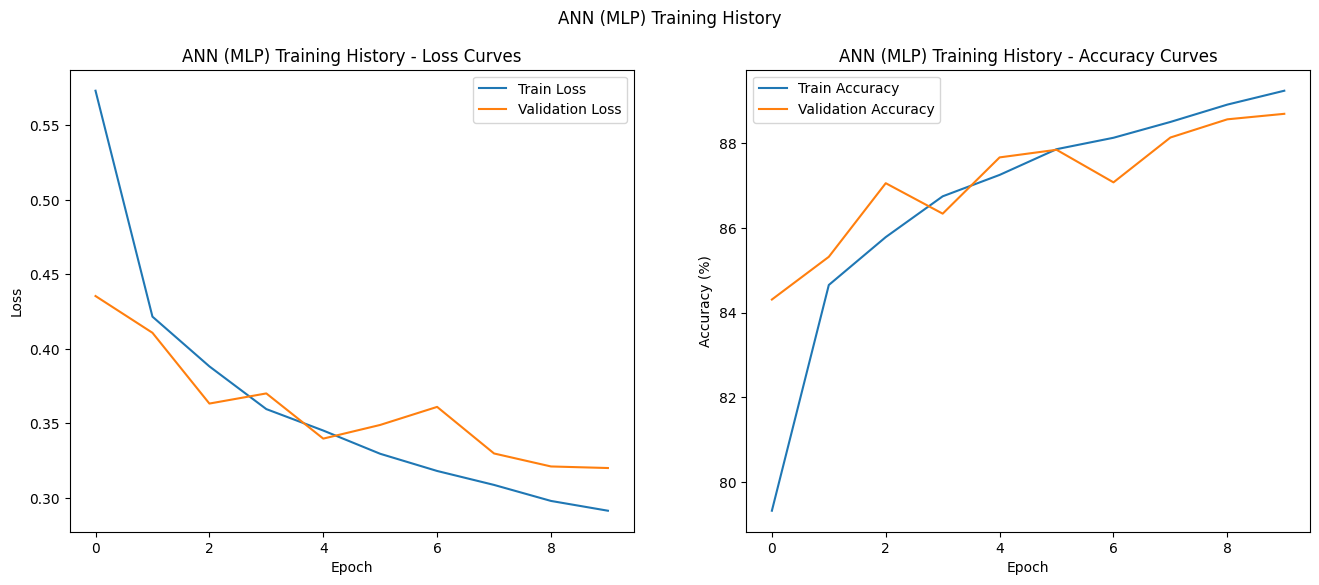

In [ ]:
print("\n--- ANN Final Evaluation ---")
ann_acc, ann_labels, ann_preds = evaluate_model(ann_model, test_loader)

print("\n--- CNN Final Evaluation ---")
cnn_acc, cnn_labels, cnn_preds = evaluate_model(cnn_model, test_loader)

# --- Plot Loss and Accuracy Curves ---
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss Curves')
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} - Accuracy Curves')
    ax2.legend()

    plt.suptitle(title)
    plt.show()

plot_history(ann_history, "ANN (MLP) Training History")

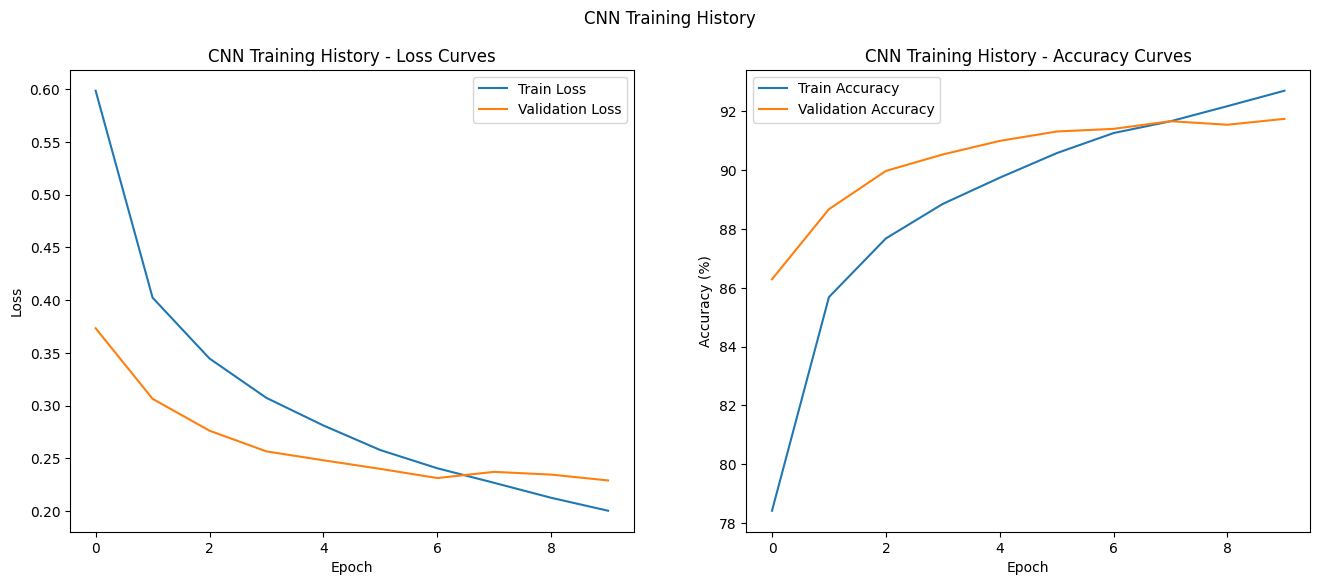

In [ ]:
plot_history(cnn_history, "CNN Training History")

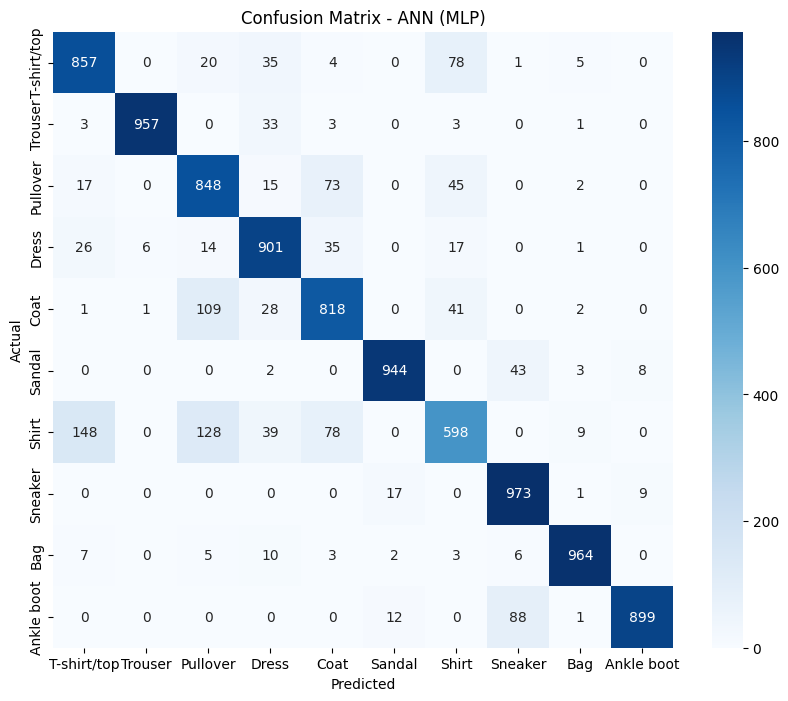

In [ ]:
# --- Plot Confusion Matrix ---
def plot_confusion_matrix(labels, preds, model_name):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

plot_confusion_matrix(ann_labels, ann_preds, "ANN (MLP)")

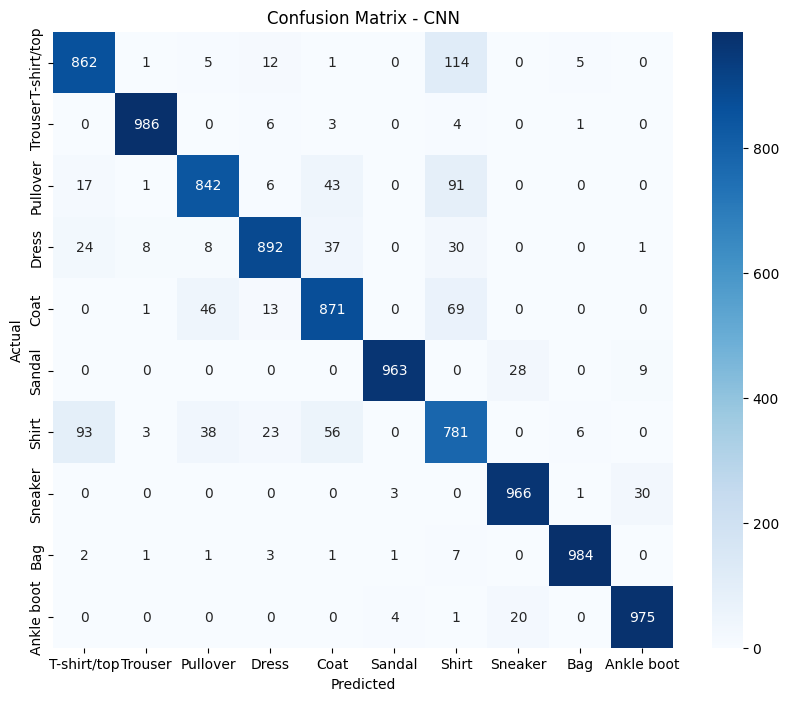


Analysis complete.


In [ ]:
plot_confusion_matrix(cnn_labels, cnn_preds, "CNN")

print("\nAnalysis complete.")